In [50]:
from utils import *
from utils import churn_analysis as churn
from IPython.display import display, HTML
import importlib
import numpy as np
import pandas as pd
from utils import eval_plots as val
import os
from sklearn.cross_validation import train_test_split


importlib.reload(churn)

data = pd.read_csv('cleantable-mb.csv', header=0, sep=',')

data = data.drop(['Target','Y2','LongTract','Zip','NextYearCount','TotalCountByTractGrade','CensusTract','GradeLevel'],axis=1)
data = data[data.SchoolYear<2010]

test_df = data[data.SchoolYear>2007] #Test set 2008, 2009
train_df = data[data.SchoolYear<=2007] # Training set from 2001 to 2007

X_train = train_df.drop('Y',1)
Y_train = train_df['Y']
X_test = test_df.drop('Y',1)
Y_test = test_df['Y']

data_descr = churn.getDfSummary(train_df)
HTML(data_descr.to_html())


,mean,std,min,25%,50%,75%,max,missing,distinct
SchoolYear,2004.000000,2.000185,2001.00000,2002.000000,2004.0,2006.000000,2007.00000,0.0,7.0
Count,20.234958,16.051674,0.00000,8.000000,17.0,29.000000,105.00000,0.0,91.0
TotalCount,15987.571429,366.135594,15258.00000,15737.000000,16081.0,16334.000000,16345.00000,0.0,7.0
TotalCountByGrade,2664.595238,113.460074,2454.00000,2606.000000,2639.5,2715.000000,2934.00000,0.0,42.0
TotalCountByTract,121.409745,92.652300,0.00000,49.000000,104.0,168.000000,495.00000,0.0,291.0
TotalCountByZip,2567.212625,846.361453,2.00000,2134.000000,2678.0,3303.000000,3573.00000,0.0,54.0
TotalCountByZipGrade,427.868771,143.544030,0.00000,357.000000,450.0,540.000000,628.00000,0.0,216.0
PrevGradeCount,16.936693,16.585808,0.00000,3.000000,13.0,26.000000,105.00000,0.0,91.0
PrevGradeCountmavg3,16.862126,16.330704,0.00000,3.000000,13.0,26.000000,105.00000,0.0,93.0
PrevGradeCountmavg5,16.934478,16.325004,0.00000,3.000000,13.0,26.000000,105.00000,0.0,93.0


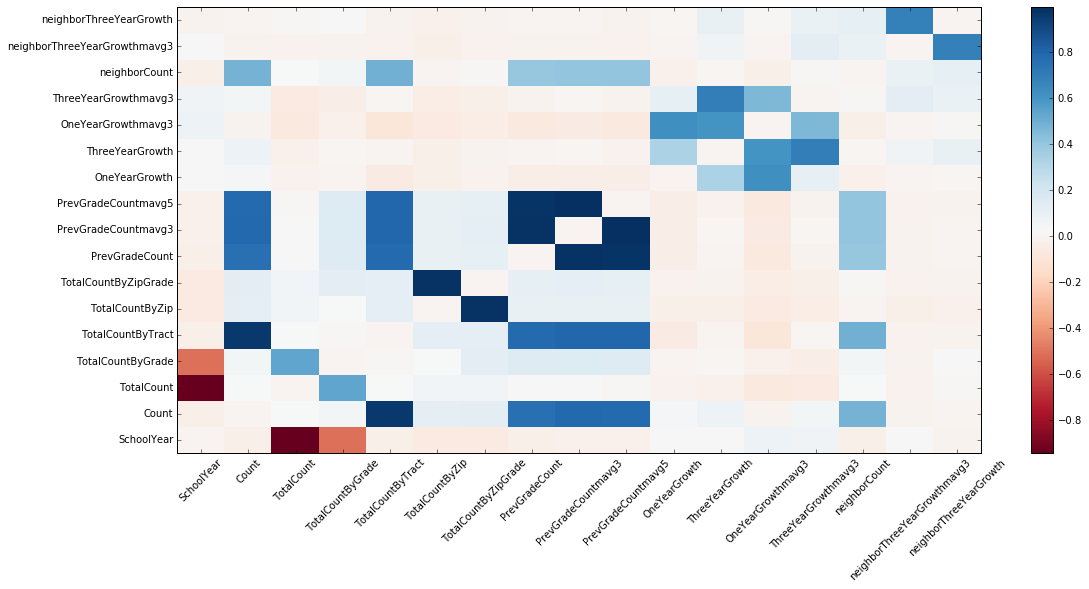

In [48]:
%matplotlib inline
import importlib
importlib.reload(churn)
cov = X_train
cov['Y'] = Y_train
churn.plotCorr(X_train, 'Y', 18, 8)


In [67]:
def liftTable(pred, truth, b):
    df = pd.DataFrame({'p':pred+np.random.rand(len(pred))*0.000001,'y':truth})
    df['b'] = b - pd.qcut(df['p'], b, labels=False)
    df['n'] = np.ones(df.shape[0])
    df_grp = df.groupby(['b']).sum()
    base = np.sum(df_grp['y'])/float(df.shape[0])
    df_grp['n_cum'] = np.cumsum(df_grp['n'])/float(df.shape[0])
    df_grp['y_cum'] = np.cumsum(df_grp['y'])
    df_grp['p_y_b'] = df_grp['y']/df_grp['n']
    df_grp['lift_b'] = df_grp['p_y_b']/base
    df_grp['cum_lift_b'] = (df_grp['y_cum']/(float(df.shape[0])*df_grp['n_cum']))/base
    
    return df_grp



             p    y      n     n_cum  y_cum     p_y_b    lift_b  cum_lift_b
b                                                                          
1   153.679551  153  155.0  0.100129    153  0.987097  1.782994    1.782994
2   144.747288  146  155.0  0.200258    299  0.941935  1.701419    1.742206
3   126.538371  136  155.0  0.300388    435  0.877419  1.584884    1.689765
4   101.406784  121  154.0  0.399871    556  0.785714  1.419237    1.622461
5    79.753103   94  155.0  0.500000    650  0.606452  1.095434    1.516919
6    60.156488   60  155.0  0.600129    710  0.387097  0.699213    1.380488
7    43.233304   57  154.0  0.699612    767  0.370130  0.668566    1.279255
8    26.467052   49  155.0  0.799742    816  0.316129  0.571024    1.190583
9    11.097205   28  155.0  0.899871    844  0.180645  0.326300    1.094414
10    2.210059   13  155.0  1.000000    857  0.083871  0.151496    1.000000
                p    y      n     n_cum  y_cum     p_y_b    lift_b  cum_lift_b
b        

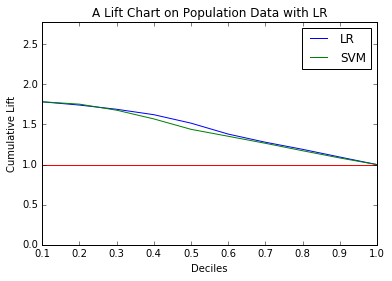

In [66]:


from sklearn import linear_model, metrics, svm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

logreg = linear_model.LogisticRegression(C = 1)
logreg.fit(X_train, Y_train)
pred_lr = logreg.predict_proba(X_test)[:,1]


lifts_lr = liftTable(pred_lr, Y_test, 10)

plt.title('A Lift Chart on Population Data with LR')
plt.plot(lifts_lr['n_cum'], lifts_lr['cum_lift_b'], label='LR')
plt.plot(lifts_svm['n_cum'], lifts_svm['cum_lift_b'], label='SVM')

plt.plot(lifts_lr['n_cum'], np.ones(lifts_lr.shape[0]))
plt.xlim([lifts_lr['n_cum'].min(), lifts_lr['n_cum'].max()])
plt.ylim([0.0, lifts_lr['cum_lift_b'].max()+1])
plt.xlabel('Deciles')
plt.ylabel('Cumulative Lift')
plt.legend()

plt.show()